# Decision Tree

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
df = pd.read_csv('preprocessed_residential_apartment.csv')
dff = df.copy()

In [3]:
df.shape

(7830, 14)

In [4]:
df.columns

Index(['DESCRIPTION', 'CITY', 'LOCALITY', 'BEDROOM_NUM', 'BATHROOM_NUM',
       'BALCONY_NUM', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'AREA', 'PRICE',
       'TOP_USPS', 'CORNER_PROPERTY', 'FURNISH_LABEL', 'PROP_DETAILS_URL'],
      dtype='object')

In [5]:
input_cols = ['CITY', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'CORNER_PROPERTY', 'FURNISH_LABEL',
             'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

In [6]:
X = df[input_cols]
y = df[target_cols]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape, X_test.shape

((6264, 9), (1566, 9))

## BaseLine Model

In [9]:
def rmse(y_act, y_pred):
    return np.sqrt(mean_squared_error(y_act, y_pred))

In [10]:
print('Train RMSE: ', rmse(y_train, np.full(len(y_train), np.mean(y_train))))
print('Test RMSE: ', rmse(y_test, np.full(len(y_test), np.mean(y_train))))

Train RMSE:  5750275.2449124
Test RMSE:  5699746.179567927


## Full Decision Tree

In [11]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2, 3, 4])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', DecisionTreeRegressor())
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [12]:
def get_error_df(cv_results):
    return pd.DataFrame(cv_results)[list(cv_results.keys())[-4:]].apply(abs)

In [13]:
def get_error_graph(errors_df):
    fig, ax1 = plt.subplots()

    # Plotting RMSE
    color = 'tab:red'
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE', color=color)
    ax1.plot(errors_df.index, errors_df['test_RMSE'], color=color, label='Test RMSE', marker='o')
    ax1.plot(errors_df.index, errors_df['train_RMSE'], color=color, label='Train RMSE', marker='x', linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='center left')

    # Create a twin Axes sharing the same x-axis for R^2 score
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('R^2 score', color=color)  
    ax2.plot(errors_df.index, errors_df['test_r2'], color=color, label='Test R^2', marker='o')
    ax2.plot(errors_df.index, errors_df['train_r2'], color=color, label='Train R^2', marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='center right')

    # Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
    fig.tight_layout()  
    plt.title('Model Evaluation Metrics per Fold')
    plt.show()

In [14]:
error_df = get_error_df(cv_results)

In [15]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

Train RMSE:  402515.74962035957    Train RMSE STD:  16915.28126076566
Test RMSE:  3028372.074956311    Test RMSE STD:  140975.73310171417


In [16]:
print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train R2:  0.9950930970362488    Train R2 STD:  0.00039231706259320155
Test R2:  0.7216360839098706    Test R2 STD:  0.006397974804412363


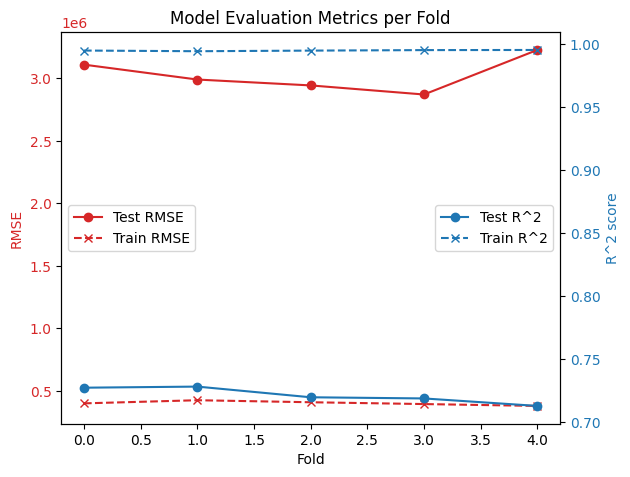

In [17]:
get_error_graph(get_error_df(cv_results))

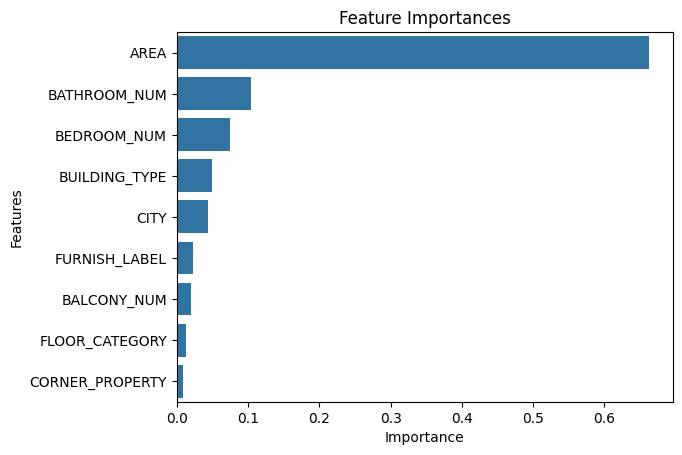

In [18]:
pipeline.fit(X_train, y_train)

feature_importances = pipeline.named_steps['model'].feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances}, index=feature_names).sort_values('Feature Importance', ascending=False)
feature_importances_df = feature_importances_df.reset_index()
feature_importances_df.columns = ['Feature', 'Feature Importance']
sns.barplot(x='Feature Importance', y='Feature', data=feature_importances_df.sort_values('Feature Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Hyper Parameter Tuning on Decision Tree

In [19]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2, 3, 4])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Define the parameter grid to search
param_grid = {
    'model__max_depth': [None, 10, 20, 30, 40, 50, 100],
    'model__min_samples_split': [2, 10, 20, 30, 40],
    'model__min_samples_leaf': [1, 5, 10, 30, 40, 50, 80],
    'model__max_features': [None, 'auto', 'sqrt', 'log2'],
    'model__splitter': ['random', 'best']
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

Best parameters found: 
{'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 30, 'model__splitter': 'best'}


In [20]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2, 3, 4])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', DecisionTreeRegressor(max_features=None, max_depth=10, min_samples_leaf=5, min_samples_split=30))
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [21]:
error_df = get_error_df(cv_results)

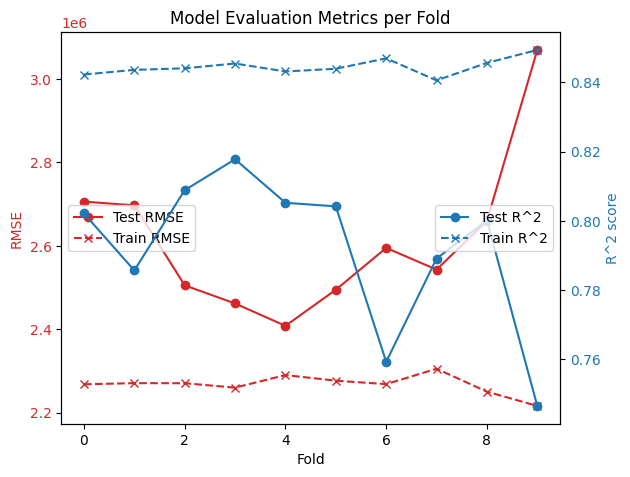

In [22]:
get_error_graph(get_error_df(cv_results))

In [23]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  2267707.1000251314    Train RMSE STD:  23654.93778294208
Test RMSE:  2614202.806503729    Test RMSE STD:  189212.17926264709
Train R2:  0.8444618461050002    Train R2 STD:  0.0024756834189683156
Test R2:  0.7919075816158119    Test R2 STD:  0.022653201229101368


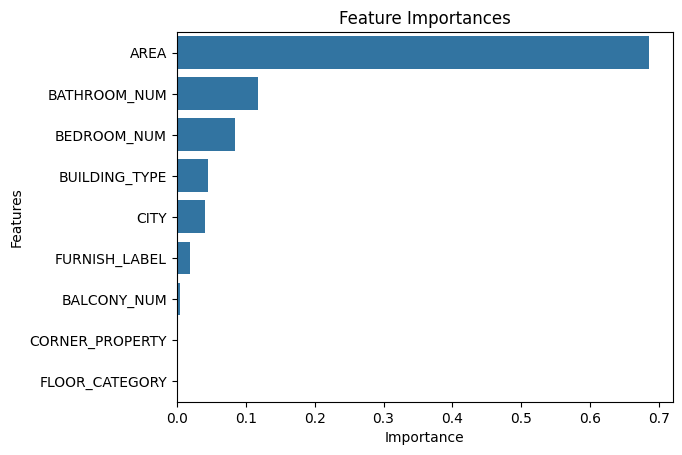

In [24]:
pipeline.fit(X_train, y_train)

feature_importances = pipeline.named_steps['model'].feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances}, index=feature_names).sort_values('Feature Importance', ascending=False)
feature_importances_df = feature_importances_df.reset_index()
feature_importances_df.columns = ['Feature', 'Feature Importance']
sns.barplot(x='Feature Importance', y='Feature', data=feature_importances_df.sort_values('Feature Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Feature Reduction

In [25]:
input_cols = ['CITY', 'BUILDING_TYPE', 'FURNISH_LABEL', 'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((6264, 7), (1566, 7))

In [26]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', DecisionTreeRegressor())
])

pipeline.fit(X_train, y_train)

# Define the parameter grid to search
param_grid = {
    'model__max_depth': [None, 10, 20, 30, 40, 50, 100],
    'model__min_samples_split': [2, 10, 20, 30, 40],
    'model__min_samples_leaf': [1, 5, 10, 30, 40, 50, 80],
    'model__max_features': [None, 'auto', 'sqrt', 'log2'],
    'model__splitter': ['random', 'best']
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

Best parameters found: 
{'model__max_depth': 50, 'model__max_features': 'auto', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__splitter': 'random'}


C:\Users\baps\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


In [27]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', DecisionTreeRegressor(max_features=None, max_depth=20, min_samples_leaf=1, min_samples_split=20, splitter='random'))
])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [28]:
error_df = get_error_df(cv_results)

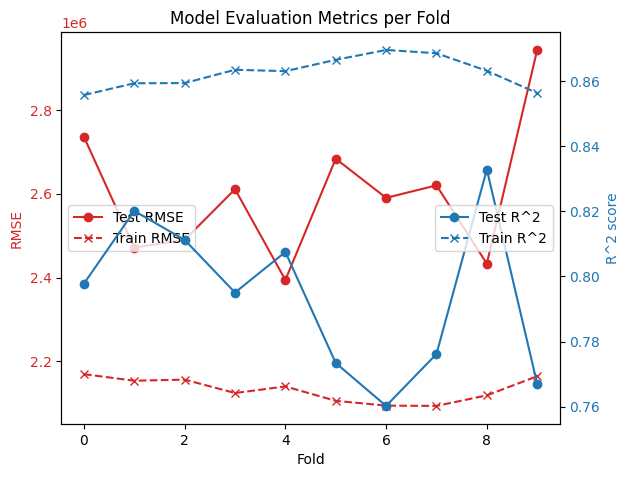

In [29]:
get_error_graph(get_error_df(cv_results))

In [30]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  2132114.378974543    Train RMSE STD:  28661.00900291504
Test RMSE:  2597341.3976860303    Test RMSE STD:  164202.85870932654
Train R2:  0.8624548856404457    Train R2 STD:  0.004804890716931338
Test R2:  0.7941177892776446    Test R2 STD:  0.024237197934705933


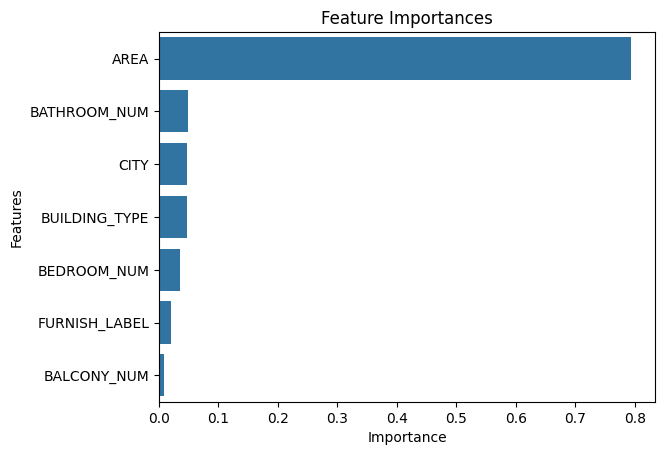

In [31]:
pipeline.fit(X_train, y_train)

feature_importances = pipeline.named_steps['model'].feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances}, index=feature_names).sort_values('Feature Importance', ascending=False)
feature_importances_df = feature_importances_df.reset_index()
feature_importances_df.columns = ['Feature', 'Feature Importance']
sns.barplot(x='Feature Importance', y='Feature', data=feature_importances_df.sort_values('Feature Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Final

In [32]:
input_cols = ['CITY', 'BUILDING_TYPE', 'FURNISH_LABEL', 'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']
target_cols = ['PRICE']

X = df[input_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), [0, 1, 2])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', DecisionTreeRegressor(max_features=None, max_depth=10, min_samples_leaf=5, min_samples_split=30))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

Train RMSE:  2280765.474966596
Test RMSE:  2433330.706313645
Train R2:  0.8426799796680196
Test R2:  0.817692757969533


In [33]:
# Train RMSE:  2279250.4613527018
# Test RMSE:  2439900.0380871943
# Train R2:  0.84288891198924
# Test R2:  0.8167070691756246